In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

#  empty graph
G = nx.Graph()

#  nodes
G.add_nodes_from([1, 2, 3, 4])

# edges 
G.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 1)])

# Draw it
nx.draw(G, with_labels=True)
plt.show()


In [ ]:
# Random Network
ER = nx.erdos_renyi_graph(n=10, p=0.3)

# Smallworld Network
WS = nx.watts_strogatz_graph(n=10, k=4, p=0.2)

# Scale-Free Network
BA = nx.barabasi_albert_graph(n=10, m=2)

# Visualize
for G, title in zip([ER, WS, BA], ['Random', 'Small-World', 'Scale-Free']):
    plt.figure()
    nx.draw(G, with_labels=True)
    plt.title(title)

plt.show()


In [ ]:
#Adding attributes to nodes
G = nx.Graph()
G.add_node(1, opinion=0.3, agreeableness=0.8)
G.add_edge(1, 2, trust=0.5)

print(G.nodes[1])        # {'opinion': 0.3, 'agreeableness': 0.8}
print(G.edges[1, 2])     # {'trust': 0.5}


In [ ]:
#Measure of influence (basic)
# influence = sigma of all incoming trust weights
def compute_influence(G, node):
    return sum(data['trust'] for _, _, data in G.in_edges(node, data=True))

# For directed graphs:
DG = nx.DiGraph()
DG.add_edge(0, 1, trust=0.9)
DG.add_edge(2, 1, trust=0.5)

print(compute_influence(DG, 1))  # Output: 1.4


person 0 has opinion -0.37601963819946493


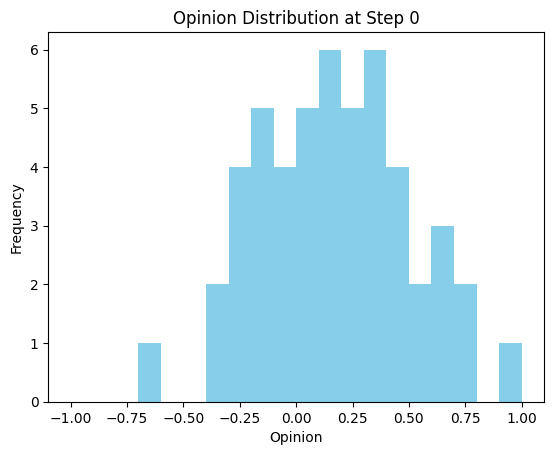

person 0 has opinion 0.4789661710677253


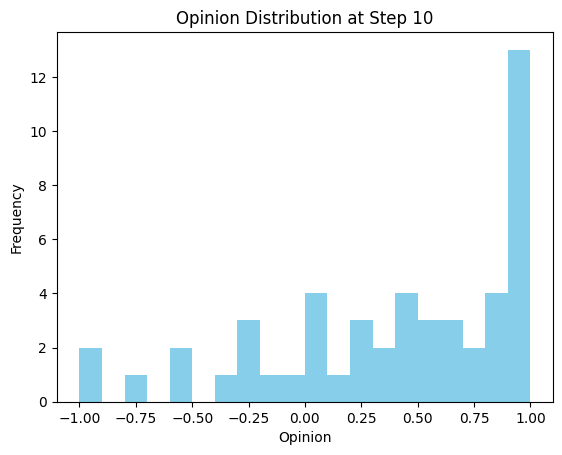

person 0 has opinion 0.43404227747120827


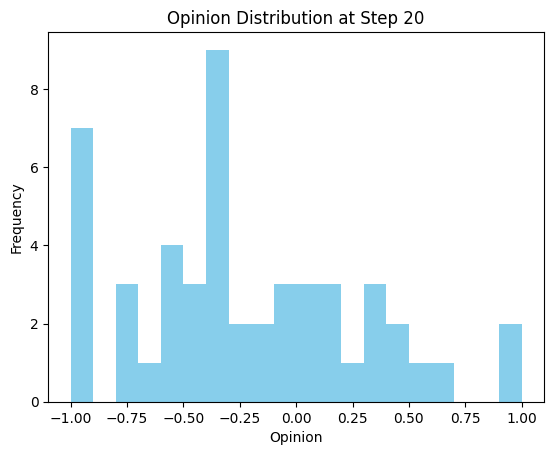

person 0 has opinion 1.0


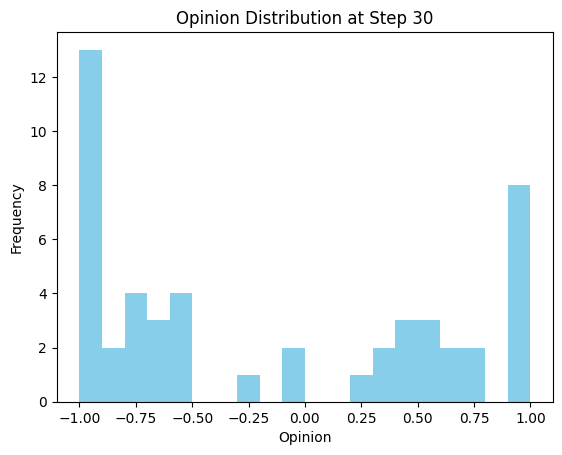

person 0 has opinion 0.3024031010522429


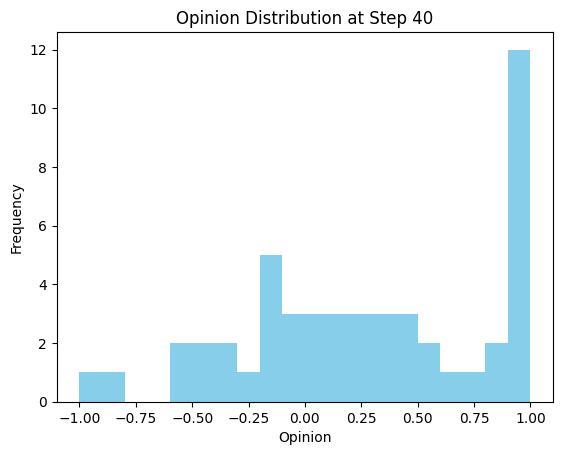

person 0 has opinion -0.5151426720402165


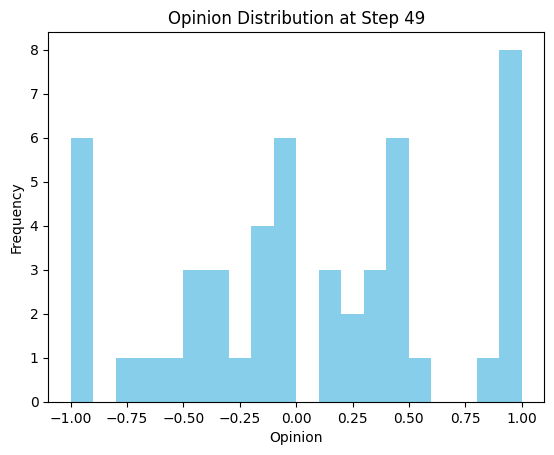

In [2]:
#Baby model: random graph/watts strogatz
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

#Problems: its not accounting for negative trust. (opinion update?)
# and it doesnt have a feedback mechanism for trust updates.

num_nodes = 50
p = 0.1  # probability of edge creation in small-world or random graph
k= 8 #in case of small-world graph
d = 0.2  # tolerance distance for feedback (corresponds to 'openness' maybe)
steps = 50

def initialize_graph():
    G = nx.watts_strogatz_graph(num_nodes, k, p) #nx.erdos_renyi_graph(num_nodes, p) 
    for node in G.nodes():
        G.nodes[node]['opinion'] = np.random.uniform(-1, 1)
        G.nodes[node]['agreeableness'] = 0.5 #np.random.uniform(0.2, 1.0)
        G.nodes[node]['loyalty'] = 0.1 #np.random.uniform(0.1, 0.9)
    for u, v in G.edges():
        G[u][v]['trust'] = np.random.uniform(0.1, 0.8)
    return G


def update_opinions(G):
    new_opinions = {}
    for i in G.nodes():
        o_i = G.nodes[i]['opinion']
        alpha_i = G.nodes[i]['agreeableness']
        total_delta = 0
        for j in G.neighbors(i):
            o_j = G.nodes[j]['opinion']
            trust_ij = G[i][j]['trust']
            delta_ij = abs(o_i - o_j)
            feedback = o_j if delta_ij <= d else -o_j
            total_delta += trust_ij * (feedback - o_i)
        new_opinions[i] = o_i + alpha_i * total_delta
    for i in G.nodes():
        G.nodes[i]['opinion'] = np.clip(new_opinions[i], -1, 1)


def update_trust(G):
    for i in G.nodes():
        eta_i = G.nodes[i]['loyalty']
        o_i = G.nodes[i]['opinion']
        for j in G.neighbors(i):
            o_j = G.nodes[j]['opinion']
            sim = 1 - abs(o_i - o_j)
            trust_old = G[i][j]['trust']
            trust_new = trust_old + eta_i * (sim - trust_old)
            G[i][j]['trust'] = np.clip(trust_new, 0, 1)


def plot_opinions(G, step):
    opinions = [G.nodes[i]['opinion'] for i in G.nodes()]
    plt.hist(opinions, bins=20, range=(-1, 1), color='skyblue')
    plt.title(f"Opinion Distribution at Step {step}")
    plt.xlabel("Opinion")
    plt.ylabel("Frequency")
    plt.show()


G = initialize_graph()
for t in range(steps):
    update_opinions(G)
    update_trust(G)
    if t % 10 == 0 or t == steps - 1:
        plot_opinions(G, t)


In [ ]:
#Aditya's model: trust update with sigmoid function
def sigmoid(x, a=10):
    return 1 / (1 + np.exp(-a * (x - 0.5)))

def sigmoid_derivative(x, a=10):
    s = sigmoid(x, a)
    return s * (1 - s)

def update_trust(G, epsilon=0.5):
    for i in G.nodes():
        eta_i = G.nodes[i]['loyalty']
        R_i = G.nodes[i]['opinion']
        for j in G.neighbors(i):
            R_j = G.nodes[j]['opinion']
            e_old = G[i][j].get('trust', 0.5)
            disagreement = abs(R_i - R_j)
            phi_prime = sigmoid_derivative(e_old)
            delta_trust = eta_i * phi_prime * (epsilon - disagreement)
            e_new = np.clip(e_old + delta_trust, 0, 1)
            G[i][j]['trust'] = e_new
